# Portfolio Optimization

“Modern Portfolio Theory (MPT), a hypothesis put forth by Harry Markowitz in his paper “Portfolio Selection,” (published in 1952 by the Journal of Finance) is an investment theory based on the idea that risk-averse investors can construct portfolios to optimize or maximize expected return based on a given level of market risk, emphasizing that risk is an inherent part of higher reward. It is one of the most important and influential economic theories dealing with finance and investment.

## Monte Carlo Simulation for Optimization Search


We could randomly try to find the optimal portfolio balance using Monte Carlo simulation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Download and get Daily Returns
aapl = pd.read_csv('AAPL_CLOSE',index_col='Date',parse_dates=True)
cisco = pd.read_csv('CISCO_CLOSE',index_col='Date',parse_dates=True)
ibm = pd.read_csv('IBM_CLOSE',index_col='Date',parse_dates=True)
amzn = pd.read_csv('AMZN_CLOSE',index_col='Date',parse_dates=True)

In [3]:
stocks = pd.concat([aapl,cisco,ibm,amzn],axis=1)
stocks.columns = ['aapl','cisco','ibm','amzn']

In [4]:
stocks.head()

,aapl,cisco,ibm,amzn
Date,,,,
2012-01-03,53.063218,15.752778,160.830881,179.03
2012-01-04,53.348386,16.057180,160.174781,177.51
2012-01-05,53.940658,15.997991,159.415086,177.61
2012-01-06,54.504543,15.938801,157.584912,182.61
2012-01-09,54.418089,16.040268,156.764786,178.56


In [5]:
mean_daily_ret = stocks.pct_change(1).mean()
mean_daily_ret

aapl     0.000750
cisco    0.000599
ibm      0.000081
amzn     0.001328
dtype: float64

In [6]:
stocks.pct_change(1).corr()

,aapl,cisco,ibm,amzn
aapl,1.000000,0.301990,0.297498,0.235487
cisco,0.301990,1.000000,0.424672,0.284470
ibm,0.297498,0.424672,1.000000,0.258492
amzn,0.235487,0.284470,0.258492,1.000000


# Simulating Thousands of Possible Allocations

In [27]:
stocks.head()

,aapl,cisco,ibm,amzn
Date,,,,
2012-01-03,53.063218,15.752778,160.830881,179.03
2012-01-04,53.348386,16.057180,160.174781,177.51
2012-01-05,53.940658,15.997991,159.415086,177.61
2012-01-06,54.504543,15.938801,157.584912,182.61
2012-01-09,54.418089,16.040268,156.764786,178.56


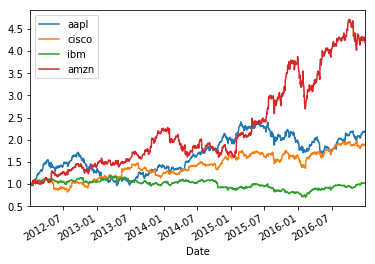

In [28]:
stock_normed = stocks/stocks.iloc[0]
stock_normed.plot()

In [29]:
stock_daily_ret = stocks.pct_change(1)
stock_daily_ret.head()

,aapl,cisco,ibm,amzn
Date,,,,
2012-01-03,NaN,NaN,NaN,NaN
2012-01-04,0.005374,0.019324,-0.004079,-0.008490
2012-01-05,0.011102,-0.003686,-0.004743,0.000563
2012-01-06,0.010454,-0.003700,-0.011481,0.028152
2012-01-09,-0.001586,0.006366,-0.005204,-0.022178


## Log Returns vs Arithmetic Returns

We will now switch over to using log returns instead of arithmetic returns, for many of our use cases they are almost the same,but most technical analyses require detrending/normalizing the time series and using log returns is a nice way to do that.
Log returns are convenient to work with in many of the algorithms we will encounter.

For a full analysis of why we use log returns, check [this great article](https://quantivity.wordpress.com/2011/02/21/why-log-returns/).


In [8]:
log_ret = np.log(stocks/stocks.shift(1))
log_ret.head()

,aapl,cisco,ibm,amzn
Date,,,,
2012-01-03,NaN,NaN,NaN,NaN
2012-01-04,0.005360,0.019139,-0.004088,-0.008526
2012-01-05,0.011041,-0.003693,-0.004754,0.000563
2012-01-06,0.010400,-0.003707,-0.011547,0.027763
2012-01-09,-0.001587,0.006346,-0.005218,-0.022428


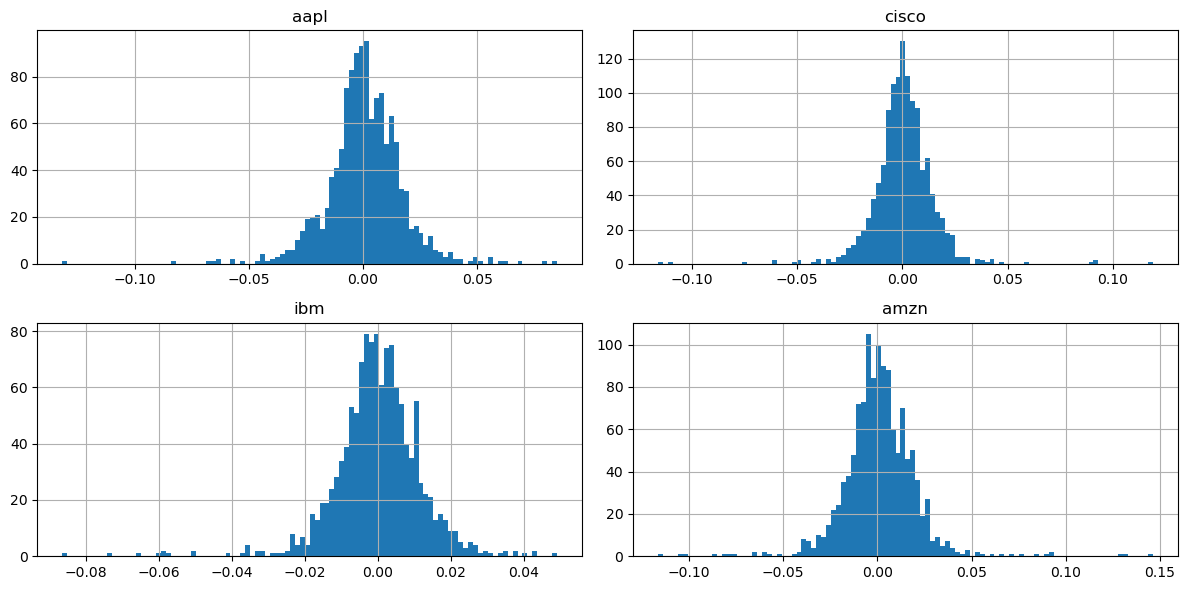

In [9]:
log_ret.hist(bins=100,figsize=(12,6));
plt.tight_layout()

In [10]:
log_ret.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
aapl,1257.0,0.000614,0.016466,-0.131875,-0.007358,0.000455,0.009724,0.085022
cisco,1257.0,0.000497,0.014279,-0.116091,-0.006240,0.000213,0.007634,0.118862
ibm,1257.0,0.000011,0.011819,-0.086419,-0.005873,0.000049,0.006477,0.049130
amzn,1257.0,0.001139,0.019362,-0.116503,-0.008534,0.000563,0.011407,0.146225


In [11]:
log_ret.mean() * 252

aapl     0.154803
cisco    0.125291
ibm      0.002788
amzn     0.287153
dtype: float64

In [12]:
# Compute pairwise covariance of columns
log_ret.cov()

,aapl,cisco,ibm,amzn
aapl,0.000271,0.000071,0.000057,0.000075
cisco,0.000071,0.000204,0.000072,0.000079
ibm,0.000057,0.000072,0.000140,0.000059
amzn,0.000075,0.000079,0.000059,0.000375


In [13]:
log_ret.cov()*252 # multiply by days

,aapl,cisco,ibm,amzn
aapl,0.068326,0.017854,0.014464,0.018986
cisco,0.017854,0.051381,0.018029,0.019956
ibm,0.014464,0.018029,0.035203,0.014939
amzn,0.018986,0.019956,0.014939,0.094470


## Single Run for Some Random Allocation

In [14]:
# Set seed (optional)
np.random.seed(101)

# Stock Columns
print('Stocks')
print(stocks.columns)
print('\n')

# Create Random Weights
print('Creating Random Weights')
weights = np.array(np.random.random(4))
print(weights)
print('\n')

# Rebalance Weights
print('Rebalance to sum to 1.0')
weights = weights / np.sum(weights)
print(weights)
print('\n')

# Expected Return
print('Expected Portfolio Return')
exp_ret = np.sum(log_ret.mean() * weights) *252
print(exp_ret)
print('\n')

# Expected Variance
print('Expected Volatility')
exp_vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
print(exp_vol)
print('\n')

# Sharpe Ratio
SR = exp_ret/exp_vol
print('Sharpe Ratio')
print(SR)


Stocks
Index(['aapl', 'cisco', 'ibm', 'amzn'], dtype='object')


Creating Random Weights
[0.51639863 0.57066759 0.02847423 0.17152166]


Rebalance to sum to 1.0
[0.40122278 0.44338777 0.02212343 0.13326603]


Expected Portfolio Return
0.15599272049632026


Expected Volatility
0.18502649565909488


Sharpe Ratio
0.8430831483926045


Great! Now we can just run this many times over!

In [15]:
num_ports = 15000

all_weights = np.zeros((num_ports,len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):

    # Create Random Weights
    weights = np.array(np.random.random(4))

    # Rebalance Weights
    weights = weights / np.sum(weights)
    
    # Save Weights
    all_weights[ind,:] = weights

    # Expected Return
    ret_arr[ind] = np.sum((log_ret.mean() * weights) *252)

    # Expected Variance
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))

    # Sharpe Ratio
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

In [16]:
sharpe_arr.max()

np.float64(1.030326055127108)

In [17]:
sharpe_arr.argmax()

np.int64(1419)

In [18]:
all_weights[1419,:]

array([0.26188068, 0.20759516, 0.00110226, 0.5294219 ])

In [19]:
max_sr_ret = ret_arr[1419]
max_sr_vol = vol_arr[1419]

## Plotting the data

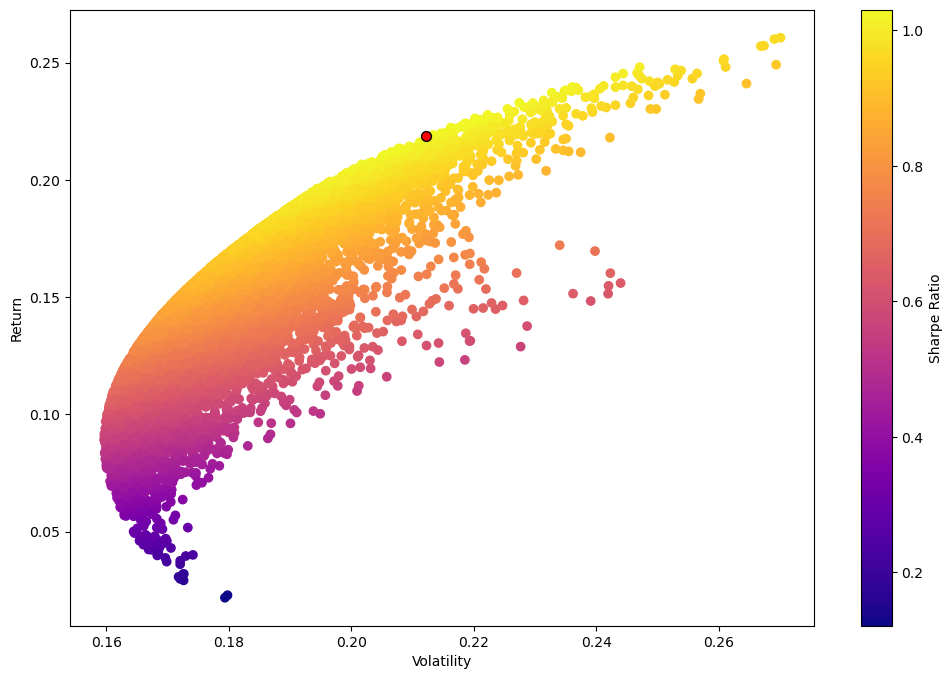

In [20]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Add red dot for max SR
plt.scatter(max_sr_vol,max_sr_ret,c='red',s=50,edgecolors='black')

# Mathematical Optimization

There are much better ways to find good allocation weights than just guess and check! We can use optimization functions to find the ideal weights mathematically!

### Functionalize Return and SR operations

In [21]:
def get_ret_vol_sr(weights):
    """
    Takes in weights, returns array or return,volatility, sharpe ratio
    """
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

In [22]:
from scipy.optimize import minimize

To fully understand all the parameters, check out:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

In [23]:
help(minimize)

Help on function minimize in module scipy.optimize._minimize:

minimize(
    fun,
    x0,
    args=(),
    method=None,
    jac=None,
    hess=None,
    hessp=None,
    bounds=None,
    constraints=(),
    tol=None,
    callback=None,
    options=None
)
    Minimization of scalar function of one or more variables.

    Parameters
    ----------
    fun : callable
        The objective function to be minimized::

            fun(x, *args) -> float

        where ``x`` is a 1-D array with shape (n,) and ``args``
        is a tuple of the fixed parameters needed to completely
        specify the function.

        Suppose the callable has signature ``f0(x, *my_args, **my_kwargs)``, where
        ``my_args`` and ``my_kwargs`` are required positional and keyword arguments.
        Rather than passing ``f0`` as the callable, wrap it to accept
        only ``x``; e.g., pass ``fun=lambda x: f0(x, *my_args, **my_kwargs)`` as the
        callable, where ``my_args`` (tuple) and ``my_kwargs`` (dic

Optimization works as a minimization function, since we actually want to maximize the Sharpe Ratio, we will need to turn it negative so we can minimize the negative sharpe (same as maximizing the postive sharpe)

In [24]:
def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1

In [25]:
# Contraints
def check_sum(weights):
    '''
    Returns 0 if sum of weights is 1.0
    '''
    return np.sum(weights) - 1

In [26]:
# By convention of minimize function it should be a function that returns zero for conditions
cons = ({'type':'eq','fun': check_sum})

In [27]:
# 0-1 bounds for each weight
bounds = ((0, 1), (0, 1), (0, 1), (0, 1))

In [28]:
# Initial Guess (equal distribution)
init_guess = [0.25,0.25,0.25,0.25]

In [29]:
# Sequential Least SQuares Programming (SLSQP).
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

In [30]:
opt_results

     message: Optimization terminated successfully
     success: True
      status: 0
         fun: -1.0307168703354028
           x: [ 2.663e-01  2.042e-01  0.000e+00  5.295e-01]
         nit: 7
         jac: [ 5.640e-05  4.183e-05  3.399e-01 -4.451e-05]
        nfev: 35
        njev: 7
 multipliers: [-4.182e-06]

In [31]:
opt_results.x

array([0.26628977, 0.20418983, 0.        , 0.52952041])

In [32]:
get_ret_vol_sr(opt_results.x)

array([0.21885915, 0.21233683, 1.03071687])

# All Optimal Portfolios (Efficient Frontier)

The efficient frontier is the set of optimal portfolios that offers the highest expected return for a defined level of risk or the lowest risk for a given level of expected return. Portfolios that lie below the efficient frontier are sub-optimal, because they do not provide enough return for the level of risk. Portfolios that cluster to the right of the efficient frontier are also sub-optimal, because they have a higher level of risk for the defined rate of return.

Efficient Frontier http://www.investopedia.com/terms/e/efficientfrontier

In [33]:
# Our returns go from 0 to somewhere along 0.3
# Create a linspace number of points to calculate x on
frontier_y = np.linspace(0,0.3,100) # Change 100 to a lower number for slower computers!

In [34]:
def minimize_volatility(weights):
    return  get_ret_vol_sr(weights)[1] 

In [35]:
frontier_volatility = []

for possible_return in frontier_y:
    # function for return
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    
    frontier_volatility.append(result['fun'])

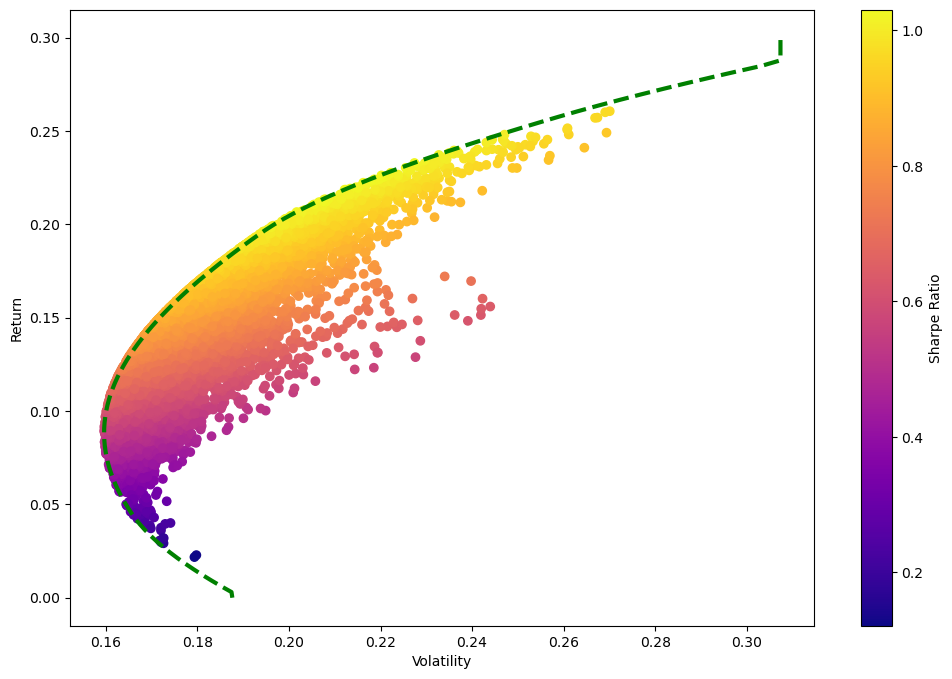

In [36]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')



# Add frontier line
plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3)

# Great Job!